In [1]:
import torch
import argparse
import random
import numpy as np
import pandas as pd
from src.graph_func import graph_construction
from src.utils_func import mk_dir, adata_preprocess, load_ST_file, res_search_fixed_clus, plot_clustering
from src.training import conST_training

import anndata
from sklearn import metrics
import matplotlib.pyplot as plt
import scanpy as sc
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--k', type=int, default=10, help='parameter k in spatial graph')
parser.add_argument('--knn_distanceType', type=str, default='euclidean',
                    help='graph distance type: euclidean/cosine/correlation')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--cell_feat_dim', type=int, default=300, help='Dim of PCA')
parser.add_argument('--feat_hidden1', type=int, default=100, help='Dim of DNN hidden 1-layer.')
parser.add_argument('--feat_hidden2', type=int, default=20, help='Dim of DNN hidden 2-layer.')
parser.add_argument('--gcn_hidden1', type=int, default=32, help='Dim of GCN hidden 1-layer.')
parser.add_argument('--gcn_hidden2', type=int, default=8, help='Dim of GCN hidden 2-layer.')
parser.add_argument('--p_drop', type=float, default=0.2, help='Dropout rate.')
parser.add_argument('--use_img', type=bool, default=False, help='Use histology images.')
parser.add_argument('--img_w', type=float, default=0.1, help='Weight of image features.')
parser.add_argument('--use_pretrained', type=bool, default=True, help='Use pretrained weights.')
parser.add_argument('--using_mask', type=bool, default=False, help='Using mask for multi-dataset.')
parser.add_argument('--feat_w', type=float, default=10, help='Weight of DNN loss.')
parser.add_argument('--gcn_w', type=float, default=0.1, help='Weight of GCN loss.')
parser.add_argument('--dec_kl_w', type=float, default=10, help='Weight of DEC loss.')
parser.add_argument('--gcn_lr', type=float, default=0.01, help='Initial GNN learning rate.')
parser.add_argument('--gcn_decay', type=float, default=0.01, help='Initial decay rate.')
parser.add_argument('--dec_cluster_n', type=int, default=10, help='DEC cluster number.')
parser.add_argument('--dec_interval', type=int, default=20, help='DEC interval nnumber.')
parser.add_argument('--dec_tol', type=float, default=0.00, help='DEC tol.')

parser.add_argument('--seed', type=int, default=0, help='random seed')
parser.add_argument('--beta', type=float, default=100, help='beta value for l2c')
parser.add_argument('--cont_l2l', type=float, default=0.3, help='Weight of local contrastive learning loss.')
parser.add_argument('--cont_l2c', type=float, default= 0.1, help='Weight of context contrastive learning loss.')
parser.add_argument('--cont_l2g', type=float, default= 0.1, help='Weight of global contrastive learning loss.')

parser.add_argument('--edge_drop_p1', type=float, default=0.1, help='drop rate of adjacent matrix of the first view')
parser.add_argument('--edge_drop_p2', type=float, default=0.1, help='drop rate of adjacent matrix of the second view')
parser.add_argument('--node_drop_p1', type=float, default=0.2, help='drop rate of node features of the first view')
parser.add_argument('--node_drop_p2', type=float, default=0.3, help='drop rate of node features of the second view')

# ______________ Eval clustering Setting ______________
parser.add_argument('--eval_resolution', type=int, default=1, help='Eval cluster number.')
parser.add_argument('--eval_graph_n', type=int, default=20, help='Eval graph kN tol.') 

params =  parser.parse_args(args=['--k', '20', '--knn_distanceType', 'euclidean', '--epochs', '200'])

np.random.seed(params.seed)
torch.manual_seed(params.seed)
torch.cuda.manual_seed(params.seed)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using device: ' + device)
params.device = device

Using device: cuda:0


In [4]:
"""
path = './data/spatialLIBD/151673'
adata_h5 = load_ST_file(path, count_file='151673_filtered_feature_bc_matrix.h5')
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
np.save('./input/adatax.npy', adata_X)
np.save('./input/graphdict.npy', graph_dict, allow_pickle = True)
"""

"\npath = './data/spatialLIBD/151673'\nadata_h5 = load_ST_file(path, count_file='151673_filtered_feature_bc_matrix.h5')\nadata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)\ngraph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)\nnp.save('./input/adatax.npy', adata_X)\nnp.save('./input/graphdict.npy', graph_dict, allow_pickle = True)\n"

In [5]:
# set seed before every run
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(params.seed)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


adata: (3639, 33538)
0.42999999999999994
===== Project: 151673 ARI score: 0.646


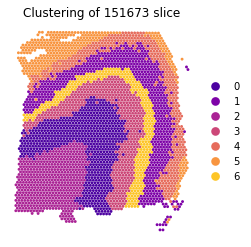

In [6]:
data_name = '151673'
save_root = './output/spatialLIBD/'
data_root = '../spatialLIBD'

params.save_path = mk_dir(f'{save_root}/{data_name}/conST')

path = '/home/yongshuo/Documents/code/research/ST/spatialLIBD/151673'
adata_h5 = load_ST_file(path, count_file='151673_filtered_feature_bc_matrix.h5')

adata_X = np.load('./input/adatax.npy')
graph_dict = np.load('./input/graphdict.npy',  allow_pickle = True).item()
params.cell_num = adata_h5.shape[0]

n_clusters = 7
if params.use_img:
    img_transformed = np.load('./MAE-pytorch/extracted_feature.npy')
    img_transformed = (img_transformed - img_transformed.mean()) / img_transformed.std() * adata_X.std() + adata_X.mean()
    conST_net = conST_training(adata_X, graph_dict, params, n_clusters, img_transformed)
else:
    conST_net = conST_training(adata_X, graph_dict, params, n_clusters)
if params.use_pretrained:
    conST_net.load_model('conST_151673.pth')
else:
    conST_net.pretraining()
    conST_net.major_training()

conST_embedding = conST_net.get_embedding()

np.save(f'{params.save_path}/conST_result.npy', conST_embedding)
# clustering
adata_conST = anndata.AnnData(conST_embedding)
adata_conST.uns['spatial'] = adata_h5.uns['spatial']
adata_conST.obsm['spatial'] = adata_h5.obsm['spatial']

sc.pp.neighbors(adata_conST, n_neighbors=params.eval_graph_n)

eval_resolution = res_search_fixed_clus(adata_conST, n_clusters)
print(eval_resolution)
cluster_key = "conST_leiden"
sc.tl.leiden(adata_conST, key_added=cluster_key, resolution=eval_resolution)

# plotting
savepath = f'{params.save_path}/conST_leiden_plot.jpg'
plot_clustering(adata_conST, cluster_key, savepath = savepath)

df_meta = pd.read_csv(f'{data_root}/{data_name}/metadata.tsv', sep='\t')
df_meta['conST'] = adata_conST.obs[cluster_key].tolist()
df_meta.to_csv(f'{params.save_path}/metadata.tsv', sep='\t', index=False)
df_meta = df_meta[~pd.isnull(df_meta['layer_guess'])]
ARI = metrics.adjusted_rand_score(df_meta['layer_guess'], df_meta['conST'])
print('===== Project: {} ARI score: {:.3f}'.format(data_name, ARI))

In [7]:
index = np.arange(start=0, stop=adata_X.shape[0]).tolist()
index = [str(x) for x in index]

def refine(sample_id, pred, dis, shape="hexagon"):
    refined_pred=[]
    pred=pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df=pd.DataFrame(dis, index=sample_id, columns=sample_id)
    if shape=="hexagon":
        num_nbs=6 
    elif shape=="square":
        num_nbs=4
    else:
        print("Shape not recongized, shape='hexagon' for Visium data, 'square' for ST data.")
    for i in range(len(sample_id)):
        index=sample_id[i]
        dis_tmp=dis_df.loc[index, :].sort_values(ascending=False)
        nbs=dis_tmp[0:num_nbs+1]
        nbs_pred=pred.loc[nbs.index, "pred"]
        self_pred=pred.loc[index, "pred"]
        v_c=nbs_pred.value_counts()
        if (v_c.loc[self_pred]<num_nbs/2) and (np.max(v_c)>num_nbs/2):
            refined_pred.append(v_c.idxmax())
        else:           
            refined_pred.append(self_pred)
    return refined_pred

dis = graph_dict['adj_norm'].to_dense().numpy() + np.eye(graph_dict['adj_norm'].shape[0])
refine = refine(sample_id = index, pred = adata_conST.obs['leiden'].tolist(), dis=dis)
adata_conST.obs['refine'] = refine

... storing 'refine' as categorical


===== Project: 151673 refined ARI score: 0.650


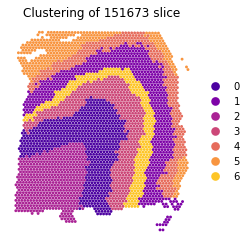

In [8]:
cluster_key = 'refine'
savepath = f'{params.save_path}/conST_leiden_plot_refined.jpg'
plot_clustering(adata_conST, cluster_key, savepath = savepath)

df_meta = pd.read_csv(f'{data_root}/{data_name}/metadata.tsv', sep='\t')
df_meta['conST_refine'] = adata_conST.obs['refine'].tolist()
df_meta.to_csv(f'{params.save_path}/metadata.tsv', sep='\t', index=False)
df_meta = df_meta[~pd.isnull(df_meta['layer_guess'])]
ARI = metrics.adjusted_rand_score(df_meta['layer_guess'], df_meta['conST_refine'])
print('===== Project: {} refined ARI score: {:.3f}'.format(data_name, ARI))

# 